In [1]:
!pip install pandas==1.5.3
!pip install pandas_datareader==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [2]:
import pandas_datareader as pdr
from datetime import datetime

In [3]:
key="API_KEY"
df=pdr.get_data_tiingo("AAPL",api_key=key)

<ipython-input-3-b7ec59fe52e0>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df=pdr.get_data_tiingo("AAPL",api_key=key)


In [4]:
df.to_csv("AAPL.csv")

In [3]:
import pandas as pd
df=pd.read_csv("AAPL.csv")

In [4]:
df2=df.reset_index()["close"]

In [5]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2019-07-29 00:00:00+00:00,209.68,210.64,208.44,208.46,21673389,50.591067,50.822693,50.291883,50.296708,86693556,0.0,1.0
1,AAPL,2019-07-30 00:00:00+00:00,208.78,210.16,207.31,208.76,33935718,50.373917,50.706880,50.019239,50.369092,135742872,0.0,1.0
2,AAPL,2019-07-31 00:00:00+00:00,213.04,221.37,211.30,216.42,69281361,51.401759,53.411601,50.981936,52.217277,277125444,0.0,1.0
3,AAPL,2019-08-01 00:00:00+00:00,208.43,218.03,206.74,213.90,54017922,50.289470,52.605734,49.881711,51.609258,216071688,0.0,1.0
4,AAPL,2019-08-02 00:00:00+00:00,204.02,206.43,201.63,205.53,40862122,49.225436,49.806915,48.648783,49.589765,163448488,0.0,1.0


In [6]:
df2.head()

0    209.68
1    208.78
2    213.04
3    208.43
4    204.02
Name: close, dtype: float64

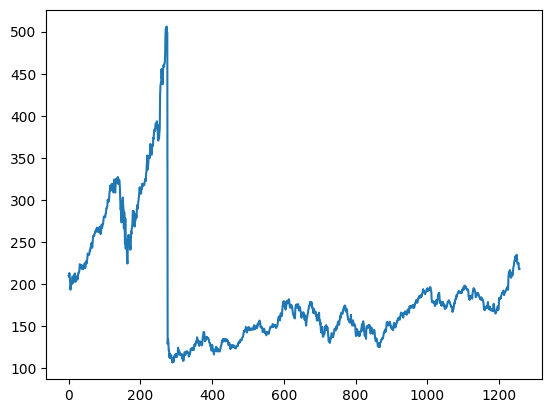

In [7]:
import matplotlib.pyplot as plt
plt.plot(df2)

In [8]:
#feature scaling since lstm is sensitive to the scale of the data
import numpy as np
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df2=sc.fit_transform(np.array(df2).reshape(-1,1))

In [9]:
df2.shape

(1258, 1)

In [10]:
#splitting the dataset
training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]

In [11]:
training_size,test_size

(817, 441)

In [12]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)


In [13]:
#reshaping X=t,t+1,t+2 and Y=t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [14]:
print(X_train)

[[0.25758297 0.25532874 0.26599875 ... 0.42156544 0.43336255 0.43474014]
 [0.25532874 0.26599875 0.2544521  ... 0.43336255 0.43474014 0.43306199]
 [0.26599875 0.2544521  0.24340639 ... 0.43474014 0.43306199 0.43376331]
 ...
 [0.08435817 0.09252348 0.107201   ... 0.09054477 0.07899812 0.08909205]
 [0.09252348 0.107201   0.10519724 ... 0.07899812 0.08909205 0.09244834]
 [0.107201   0.10519724 0.10487163 ... 0.08909205 0.09244834 0.09272386]]


In [15]:
X_test.shape,y_test.shape

((340, 100), (340,))

In [16]:
print(X_train)

[[0.25758297 0.25532874 0.26599875 ... 0.42156544 0.43336255 0.43474014]
 [0.25532874 0.26599875 0.2544521  ... 0.43336255 0.43474014 0.43306199]
 [0.26599875 0.2544521  0.24340639 ... 0.43474014 0.43306199 0.43376331]
 ...
 [0.08435817 0.09252348 0.107201   ... 0.09054477 0.07899812 0.08909205]
 [0.09252348 0.107201   0.10519724 ... 0.07899812 0.08909205 0.09244834]
 [0.107201   0.10519724 0.10487163 ... 0.08909205 0.09244834 0.09272386]]


In [19]:
#reshaping the input to be [samples,time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [22]:
#Importing necessry libraries
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential

In [23]:
#creation of stacked lstm
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 336ms/step - loss: 0.0390 - val_loss: 9.5542e-04
Epoch 2/100
12/12 [==============================] - 3s 282ms/step - loss: 0.0127 - val_loss: 0.0011
Epoch 3/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0124 - val_loss: 6.8252e-04
Epoch 4/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0102 - val_loss: 4.8014e-04
Epoch 5/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0086 - val_loss: 4.7203e-04
Epoch 6/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0078 - val_loss: 2.8527e-04
Epoch 7/100
12/12 [==============================] - 2s 186ms/step - loss: 0.0071 - val_loss: 3.9872e-04
Epoch 8/100
12/12 [==============================] - 3s 255ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 9/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0064 - val_loss: 7.8469e-04
Epoch 10/100
12/12 [==============================] - 2s 169ms

In [30]:
#evaluation of the model
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 35ms/step


In [32]:
train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

In [33]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

209.07519444552412

In [34]:
math.sqrt(mean_squared_error(y_test,test_predict))

182.12178924618206

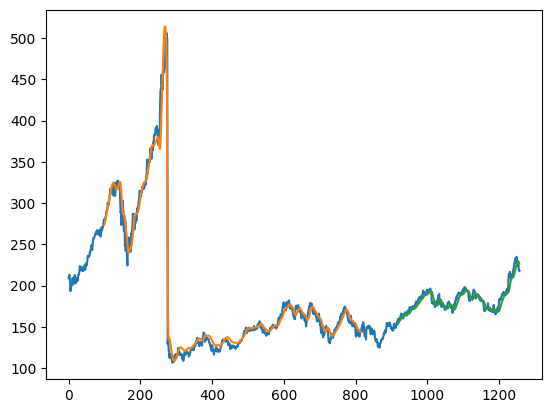

In [36]:
look_back=100
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
# plot baseline and predictions
plt.plot(sc.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [38]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [39]:
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.29194218]
101
1 day input [0.15599249 0.15569192 0.16002505 0.16508453 0.16628679 0.16102693
 0.16571071 0.16475892 0.16751409 0.17342517 0.17991234 0.16162805
 0.16390733 0.16032561 0.15747026 0.16648716 0.16190357 0.15827176
 0.15529117 0.15731997 0.15524108 0.15714465 0.15431434 0.15737007
 0.15263619 0.17082029 0.17460238 0.16493425 0.15664371 0.15318723
 0.15078272 0.14567314 0.14777708 0.15043206 0.15574202 0.1579211
 0.15644333 0.16696306 0.15902317 0.15644333 0.16578585 0.19170946
 0.18752661 0.18925485 0.19010645 0.19469004 0.19088291 0.19897307
 0.20185348 0.20758923 0.20788979 0.20796493 0.21089543 0.21417658
 0.21054477 0.20047589 0.20824045 0.2082655  0.20901691 0.2115216
 0.21392611 0.21838447 0.21918597 0.22299311 0.21951158 0.2255479
 0.2161052  0.25124609 0.26607389 0.26900438 0.26462116 0.2750908
 0.26912962 0.25758297 0.25209768 0.25372574 0.2560551  0.26652473
 0.26865373 0.25993738 0.27529117 0.2841077  0.28731371 0.29931121
 0.30301816 0.3051722  0.31594239 0.3

In [40]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [42]:
plt.plot(day_new,sc.inverse_transform(df1[1158:]))
plt.plot(day_pred,sc.inverse_transform(lst_output))

NameError: name 'df1' is not defined

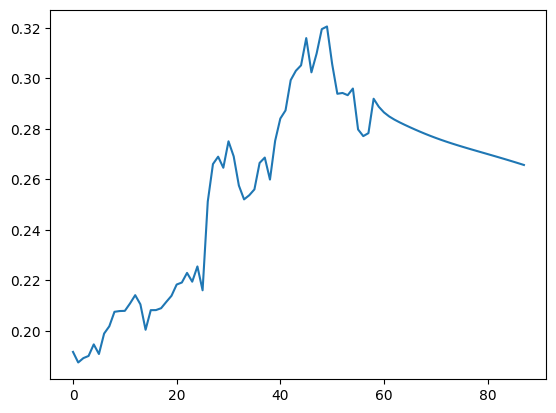

In [43]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])